## Homework 3.4: Exploring recombination (30 pts)

<hr>

In this problem, we will be exploring diversity generation using recombination. You should read [this paper by Drummond and coworkers](https://doi.org/10.1073/pnas.0500729102) to do this problem.

## Part a

Why are mutations generated by recombination more conservative than those generated by random mutagenesis? Why might homologous recombination be more beneficial than random mutagenesis?

<hr>

Mutations generated by recombinaion are more conservative than those generated by random mutagenesis because the experimenter is combining pre-exisiting homologous proteins. These homologous proteins can have highly conserved positions, meaning that there is no genetic diversity at this position. Random mutagenesis is independent of conservation, so highly conserved positions are just as likely to be mutated as any other position. However, homologous recombination might be more beneficial than random mutagenesis because it is more likely to maintain stability. Highly conserved residues in homologous proteins may significantly contribute the proteins' stabilities. Therefore, randomly mutating these positions can result in inactive variants. 

## Part b

Write a function that given aligned parental sequences, block assignments, and a block design, outputs the chimeric sequence. Your function should be able to accept any number of parents and any number of contiguous or non-contiguous blocks. You can use the partial function below with doc string and some input checking.

In [1]:
def get_sequence(parents, block_assignments, block_design):
    """Derive a chimeric sequence.

    Parameters
    ----------
    parents : list
        A list containing the aligned parent sequences as strings.
    block_assignments : iterable of ints
        Iterable of ints mapping each position to a block.
    block_design : iterable of ints
        Which parent to use for each block. For example, [1, 2, 0]
        would mean:
            the 2nd parent for block 0
            the 3rd parent for block 1
            the 1st parent for block 2

    Returns
    -------
    chimera : str
        Sequence of the chimera.
    """
    if max(block_design) >= len(parents):
        raise ValueError("More blocks than there are parents.")
    if len(list(set([len(parent) for parent in parents]))) != 1:
        raise ValueError("Parents must all be the same length.")
    if len(block_assignments) != len(parents[0]):
        raise ValueError(
            "Length of block assignments does not match length of parents."
        )
    if len(block_design) != max(block_assignments) + 1:
        raise ValueError("Length of block design does not match number of blocks.")
    
    # map blocks to parents
    design_dict = {i:parents[b] for i, b in enumerate(block_design)}

    # build chimera
    chimera = ""
    for i, a in enumerate(block_assignments):
        chimera += design_dict[a][i]
    
    return chimera

As a simple test case, the code block below should execute silently.

In [2]:
# A simple test case (just to test function; B is not valid AA)
parents = [
    "AAAAAAAAAA",
    "BBBBBBBBBB",
    "CCCCCCCCCC",
]
assignments = [0, 1, 0, 2, 2, 3, 1, 1, 0, 3]
design = [0, 1, 0, 2]

assert get_sequence(parents, assignments, design) == "ABAAACBBAC"

<hr>

## Part c

Write a function that, given a sequence and the locations of contacting residues, returns the contacts. We'll use this to precalculate the parental contacts once and avoid recalculating them every time we need them.  

In [3]:
def get_contacts(seq, contacting_terms):
    """ Calculate contacts. 
    
    Parameters
    ----------
    seq : str
        Input sequence.
    contacting_terms : list of tuples
        List of tuples (i, j) where i and j are positions 
        in `seq` that are in contact.
            
    Returns
    -------
    contacts : list of tuples
        Contacts as a list of tuple where each tuple as
        (i, aa1, j, aa2).
    """
    contacts = []

    for t in contacting_terms:
        contacts.append((t[0], seq[t[0]], t[1], seq[t[1]]))

    return contacts

You can use the simple test case below to help you.

In [4]:
# A simple test case.
seq = "ABCDEFG"
terms = [(0, 1), (2, 5), (3, 4)]
contacts = [(0, "A", 1, "B"), (2, "C", 5, "F"), (3, "D", 4, "E")]
my_contacts = sorted(get_contacts(seq, terms))
for c, m in zip(contacts, my_contacts):
    assert c == m

<hr>

## Part d

Write a function that, given a chimeric sequence, parental contacts, and the locations of contacting residues, returns the SCHEMA energy for the chimeric sequence. You should use your implementation of get_contacts. 

The call signature and doc string are shown below.

In [5]:
def calc_schema_energy(seq, parent_contacts, contacting_terms):
    """Calculate the SCHEMA energy for a chimeric sequence.
    
    Parameters
    ----------
    seq : str
        The chimeric sequence.
    parent_contacts : list
        The parental contacts.
    contacting_terms :list of tuples
        List of tuples (i, j) where i and j are positions 
        in `seq` that are in contact.
            
    Returns
    -------
    output : int
        The SCHEMA energy.
    """

    # get contacts for chimera
    chimera_contacts = get_contacts(seq, contacting_terms)

    # calculate energy
    energy = 0
    for i, c in enumerate(chimera_contacts):
        p_list = [p[i] for p in parent_contacts]
        if c not in p_list:
            energy += 1

    return energy

Again, here is a simple test case.

In [6]:
# A simple test case.
parent_contacts = [
    [(0, "A", 1, "B"), (2, "C", 5, "F"), (3, "D", 4, "E")],
    [(0, "A", 1, "C"), (2, "C", 5, "E"), (3, "D", 4, "E")],
    [(0, "A", 1, "B"), (2, "B", 5, "F"), (3, "D", 4, "A")],
]
seq = "ACBDAE"
contacting_terms = [(0, 1), (2, 5), (3, 4)]
assert calc_schema_energy(seq, parent_contacts, contacting_terms) == 1

<hr>

## Part e

Write a function that, given a chimeric sequence and aligned parental sequences, calculates the Hamming distance from each of the parents. The Hamming distance between two strings is the number of locations at which they differ. Following is a call signature with doc string./

In [7]:
def hamming_distance(seq, parents):
    """Calculate the Hamming distances between a sequence and its parents. 
    
    Parameters
    ----------
    seq : str 
        The chimeric sequence.
    parents : list of strs 
        A list containing the aligned parent sequences as strings. 

    Returns
    -------
    dists : list
        A list containing the Hamming distances between each parent and `seq`.
    """

    hamming_dist = []

    for p in parents:
        hamming_dist.append(sum([1 for s, pp in zip(seq, p) if s != pp]))

    return hamming_dist


And again a test case.

In [8]:
# A simple test case.
ps = ["ABCDEF", "ACBFED", "BBCFGH"]
s = "ACBFEF"
ds = hamming_distance(s, ps)
actual_ds = [3, 1, 5]
for d, da in zip(ds, actual_ds):
    assert d == da

<hr>

## Part f

Given aligned parental sequences in parents.txt, their contacts in contacts.txt, and the SCHEMA block assignments in assignments.txt: 

1. Generate all the sequences in the described recombination library. 
2. Generate $3^{10}$ sequences by randomly shuffling the parental amino acids at each position.
3. Calculate the SCHEMA energy for each of the chimeras you generated in parts 1 and 2. 
4. Calculate the Hamming distance to the nearest parent for each of the chimeras you generated in parts 1 and 2. 
5. Plot the Hamming distance against the SCHEMA energy for both libraries on one set of axes.

The code block below may be used to read in the parents, contacts, and assignments.

In [9]:
with open("parents.txt") as f:
    parents = f.read().split("\n")[:-1]

with open("contacts.txt") as f:
    contacts = f.read().split("\n")[:-1]
contacts = [(int(c.split(",")[0][1:]), int(c.split(", ")[1][:-1])) for c in contacts]

with open("assignments.txt") as f:
    assignments = f.read().split("\n")[:-1]
assignments = [int(a) for a in assignments]

Comment on the relative diversity and stability of each library. How does the SCHEMA energy relate to the probability that a chimera will fold?

<hr>

In [10]:
import itertools
import random

In [11]:
# Generate list of block_designs for task (1).
num_parents = len(parents)
num_blocks = max(assignments) + 1
parent_ids = []
for i in range(num_parents):
    parent_ids.append(i)

block_designs = list(itertools.product(parent_ids, repeat=num_blocks))

In [12]:
recomb_lib_1 = []

for b in block_designs:
    recomb_lib_1.append(get_sequence(parents, assignments, b))

In [13]:
recomb_lib_2 = []

for i in range(3**10):
    temp_seq = ''
    for p in range(len(parents[0])):
        temp_seq += random.choice(parents)[p]
    recomb_lib_2.append(temp_seq)

In [14]:
parent_contacts = [get_contacts(p, contacts) for p in parents]

schema_1 = []
for r in recomb_lib_1:
    schema_1.append(calc_schema_energy(r, parent_contacts, contacts))

schema_2 = []
for r in recomb_lib_2:
    schema_2.append(calc_schema_energy(r, parent_contacts, contacts))

In [15]:
hd_1 = []
for r in recomb_lib_1:
    hd_1.append(hamming_distance(r, parents))

hd1_shortest = [min(hd) for hd in hd_1]

hd_2 = []
for r in recomb_lib_2:
    hd_2.append(hamming_distance(r, parents))

hd2_shortest = [min(hd) for hd in hd_2]

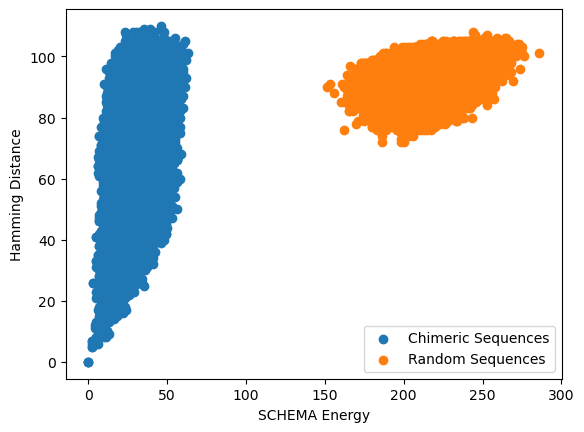

In [16]:
import matplotlib.pyplot as plt
plt.scatter(schema_1, hd1_shortest, label='Chimeric Sequences')
plt.scatter(schema_2, hd2_shortest, label='Random Sequences')

plt.xlabel('SCHEMA Energy')
plt.ylabel('Hamming Distance')
plt.legend()

The random sequence library has a much greater library diversity because all the variants have a large hamming distance value. Many sequences in the chimeric library have low hamming distances, so the library has less diversity overall. The chimeric library has higher stability based on the much lower SCHEMA energy values. Chimeric proteins are more likely to fold when the connections between their independnent blocks are maintained. The SCHEMA energy is a measure of the disruption of these connections and is therefore used to predict stability. 

<br />